In [236]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Audio
%matplotlib inline
plt.rcParams['figure.dpi']= 150

# A simple time-dependent model of kidney

Consider a multidomain type model on a (rescaled) spatial domain $\Omega = (0,1)$, on which we have a non-dimensionalized system:
\begin{align}
    \frac{\partial \alpha_k}{\partial t}  + \frac{\partial}{\partial x}\left( \alpha_k u_k \right) &= - w_k,\\
    \frac{\partial\alpha_0}{\partial t}+\frac{\partial}{\partial x}\left( \alpha_0 u_0 \right) &=\sum_k w_k,\\
    \frac{\partial}{\partial t}\left( \alpha_k c_i^k \right)&=-\frac{\partial}{\partial x} f_i^k - g_i^k,\\
    \frac{\partial}{\partial t}\left( \alpha_0 c_i^0 \right)&=-\frac{\partial}{\partial x} f_i^0 + \sum_k g_i^k,\\
    \nu_k\left( p_k - p_0 \right) &= \frac{\alpha_k}{\bar{\alpha}_k}-1,\\
    \alpha_0 + \sum_{k} \alpha_k &= \alpha_*,
\end{align}
    where $k$ represents ascending ($\mathrm{A}$), descending ($\mathrm{D}$) and collecting ($\mathrm{C}$) tubules of a homogeneous population of nephrons, and
\begin{align}
    \frac{\rho_\cdot}{\alpha_\cdot}u_\cdot &= -\frac{\partial p_\cdot}{\partial x},\\
    f_i^\cdot&=  \alpha_\cdot u_\cdot c_i^\cdot ,\\
    %f_i^\cdot&=  \alpha_\cdot u_\cdot c_i^\cdot ,\quad \mu_i^\cdot:=\ln c_i^k \\
    w_k&= \zeta_k\left( \psi_k-\psi_0 \right),\quad\psi_\cdot := p_\cdot - \pi_.,\quad \pi_\cdot := \frac{a_\cdot}{\alpha_\cdot}+\sum_i c_i^\cdot,\\
    g_i^k &= j_i^k+h_i^k,\quad j_i^k :=\gamma_i^k(\mu_i^k-\mu_i^0).
    % := \ln\left( \frac{c_i^k}{c_i^0} \right).
\end{align}
The subscript $i$ here represents solute species, namely, salt and urea, and $\cdot$ is to be replaced by $\mathrm{A,D,C},0$.

We can see that the physical parameters of the dimensionless model are $\rho_\cdot, D_i^\cdot, \nu_k, \bar{\alpha}_k, \alpha_*,a$.
In this simulation, we will use $\alpha_* = 1$, $a=0$, and $\bar{\alpha}_k = 1/4$.
For the transport parameters, we have $\zeta_k,\gamma_i^k$.
For illustrating purpose, we assume that
\begin{equation}
    h_\mathrm{salt}^\mathrm{A} = h_*(c_\mathrm{salt}^\mathrm{A})^+,\quad \text{on}\quad (0,1/2),
\end{equation}
    where $h_*>0$ is the pump strength.

In [237]:
L = 1 # cm
c_star = 0.001 # mmol/mL
RT = 19344 # mmHg.mL/mmol
rad_0 = 0.0025 # cm
rad_D = 0.0008 # cm
rad_A = 0.001 # cm
rad_C = 0.0012 # cm
area_0 = np.pi*rad_0**2 # cm^2
area_D = np.pi*rad_D**2 # cm^2
area_A = np.pi*rad_A**2 # cm^2
area_C = np.pi*rad_C**2 # cm^2
area_tot = (area_0 + area_D + area_A + area_C)/1 # cm^2
# circ_0 = 2*np.pi*rad_0 # cm
circ_D = 2*np.pi*rad_D # cm
circ_A = 2*np.pi*rad_A # cm
circ_C = 2*np.pi*rad_C # cm
pressure = c_star*RT
hydr_resist = 8*0.6915*np.pi**2*(0.0075*10**(-3)) # mmHg.s (take \eta=0.6915 cP)
rho_interst = 8*3.5*np.pi**2*(0.0075*10**(-3)) # mmHg.s
tau = hydr_resist*L**2/(area_tot*pressure)
F_PCT = 0.167e-6 # cm^3/s
P_v = 0 #mmHg
P_p = 6.4 #mmHg
D = np.zeros([2,4])
D[0,0] = 0.00025 # cm^2/s
D[1,0] = 0.0002 # cm^2/s
D[0,1:] = 1.5e-5 # cm^2/s
D[1,1:] = 1.5e-5 # cm^2/s
pump_strength = 14.2e-6 # mmol/cm^2.s pump strength

# parameters
rho = np.ones(4)
rho[0] = rho_interst/hydr_resist
D = D*tau/L**2
pump_strength = pump_strength*circ_A*tau/(area_tot*c_star) # dim-less
nu = np.ones(4)
alpha_bar = np.zeros(4)
alpha_bar[0] = area_0/area_tot
alpha_bar[1] = area_D/area_tot
alpha_bar[2] = area_A/area_tot
alpha_bar[3] = area_C/area_tot
alpha_star = 1
colloid = 0.01
q = 1/3
F_PCT = F_PCT*tau/(area_tot*L)
P_v = P_v/pressure
P_p = P_p/pressure


# filtrates = np.array([1.8,0.2]) # more realistic filtrated salt and urea
filtrates = np.array([145,5]) # test filtrated salt and urea
c_cortex = 2*filtrates[0]+filtrates[1]

def psi(k,c,p): # c is an (2,4,N+1)-array, p is an (4,N+1)-array
    return p[k,:] - pi(k,c)

def pi(k,c): # c is an (2,4,N+1)-array
    if k==0:
        return 2*c[0,k,:]+c[1,k,:]+colloid
    else: 
        return 2*c[0,k,:]+c[1,k,:]

def mu(i,k,c): # c is an (2,4,N+1)-array
    # return np.log(c[i,k,:])
    return c[i,k,:] # when using Stephenson's model

Let $N\in \mathbb{N}$ be the number of uniformly spaced grids in $(0,1)$, and $\delta x = 1/N$ be the spatial grid size.
Similarly, we denote $\delta t$ as the size of time steps.
We will use the notation $\alpha^{n}_{kl},c_{il}^{kn}, p_{kl}^{n}$, $k=0,\mathrm{D},\mathrm{A},\mathrm{C}$, $1\leq l\leq N$, for the discretization of $\alpha_k,c_i^k$ and $p_k$ in the $l$-th spatial grid and time $t = n\delta t$.

In [238]:
N = 80 # the number of spatial grid
dt = 0.1 # time step size
dx = 1/N # spatial grid size

# now we can define spatially heterogeneous parameters
zeta = np.zeros([3,N])
gamma = np.zeros([2,3,N])
for l in range(N):
    zeta[2,l] = 3e-5/760 # cm/mmHg.s col water permeability
    gamma[0,0,l] = 1.61e-5 # cm/s desc salt permeability
    gamma[0,2,l] = 0.04e-5 # cm/s, col salt permeability
    gamma[1,0,l] = 1.5e-5 # cm/s desc urea permeability
    if l<=round(0.4*N):
        zeta[0,l] = 17.1e-5/760 # cm/mmHg.s, desc water permeability
        gamma[0,1,l] = 6.27e-5 # cm/s, asc salt permeability
        gamma[1,1,l] = 0.86e-5 # cm/s, asc urea permeability
    elif l<=round(0.6*N):
        zeta[0,l] = 25.7e-5/760 # cm/mmHg.s, desc water permeability
        gamma[0,1,l] = 26e-5 # cm/s, asc salt permeability
        gamma[1,1,l] = 6.7e-5 # cm/s, asc urea permeability
    else:
        zeta[0,l] = 20.4e-5/760 # cm/mmHg.s, desc water permeability
        gamma[0,1,l] = 26e-5 # cm/s, asc salt permeability
        gamma[1,1,l] = 6.7e-5 # cm/s, asc urea permeability
        gamma[1,2,l] = 1.5e-5 # cm/s col urea permeability

zeta[0,:] = zeta[0,:]*circ_D*pressure*tau/area_tot
zeta[1,:] = zeta[1,:]*circ_A*pressure*tau/area_tot
zeta[2,:] = zeta[2,:]*circ_C*pressure*tau/area_tot

gamma[:,0,:] = gamma[:,0,:]*circ_D*tau/(area_tot)
gamma[:,1,:] = gamma[:,1,:]*circ_A*tau/(area_tot)
gamma[:,2,:] = gamma[:,2,:]*circ_C*tau/(area_tot)

def AHL_pump(c_salt):
    pump = np.zeros(N)
    mm = 0.15/c_star
    for l in range(round(0.4*N)):
    # for l in range(N):
        # pump[l] = pump_strength*np.maximum(0,c_salt[l])
        pump[l] = pump_strength/(1+mm/c_salt[l]) # Michaelis-Menten
    return pump

We will use an implicit scheme to update the unknown for each time step.

First, we define difference quotient operators:
\begin{equation}
    \Delta_x^+y^n_l:= \frac{y^n_{l+1}-y^n_{l}}{\delta x},\quad \Delta_x^- y^n_l :=\frac{y^n_l-y^n_{l-1}}{\delta x},\quad \Delta_t y^n_l = \frac{y^n_l - y^{n-1}_l}{\delta t},
\end{equation}
and an average operator:
\begin{equation}
    Ay_l^n := \frac{y^n_{l+1}+y^n_l}{2}.
\end{equation}


In [239]:
def diff_x(y): 
    n = len(y)-1
    diff = np.zeros(n)
    for l in range(n):
        diff[l] = (y[l+1]-y[l])/dx
    
    return diff

# def diff_bw(y): 
#     n = len(y)-1
#     diff = np.zeros(n)
#     for l in range(1,n+1):
#         diff[l] = (y[l]-y[l-1])/dx
    
#     return diff

def diff_t(y_1,y_0): 
    return (y_1-y_0)/dt

def average(y):
    n = len(y)-1
    avg = np.zeros(n)
    for l in range(n):
        avg[l] = (y[l+1]+y[l])/2
    
    return avg

## Implicit scheme

Now, we give a method for computing residual of the implicit function for each time step.
The equations for the volumes are
\begin{gather}
    \Delta_t \alpha_{kl}^n +\mathrm{Pe}\Delta_x^-((A\alpha_{kl}^n) u_{kl}^n) = -w_{kl}^{n},\quad w_{kl}^n:=\zeta_k\left( \psi_{kl}^n-\psi_{0l}^n \right)\\
    \psi_{\cdot l}^n:= p_{.l}^n - \pi_{\cdot l}^n,\quad \pi_{\cdot l}^n:= \sum_i c_{il}^{\cdot n},\nonumber
\end{gather}
and
\begin{equation}
    \Delta_t \alpha_{0l}^n +\mathrm{Pe}\Delta_x^-(\alpha_{0l}^n u_{0l}^n) = \sum_k w_{kl}^{n}.
\end{equation}


In [240]:
def water_trans(k,c,p): 
    return zeta[k-1,:]*(psi(k,c,p) - psi(0,c,p))

def p_junction(k,alpha,c,p):
    if k == 1:
        n = -1
        return (alpha[k,n]**2*p[k,n]/rho[k] + alpha[k+1,n]**2*p[k+1,n]/rho[k+1])/(alpha[k,n]**2/rho[k]+alpha[k+1,n]**2/rho[k+1])
    elif k == 2:
        n = 0
        return (
                (alpha[k,n]**2*(2*q*c[0,k,n]+c[1,k,n])*p[k,n]/rho[k] 
                    + alpha[k+1,n]**2*c_cortex*p[k+1,n]/rho[k+1])
                /(alpha[k,n]**2*(2*q*c[0,k,n]+c[1,k,n])/rho[k]
                  + alpha[k+1,n]**2*c_cortex/rho[k+1])
                )

def DCT_junction(y,alpha,c,p): # y = (c_u,c_s,p_junc)
    res = np.zeros(3)
    res[0] = (
                q*(alpha[2,0]**2/rho[2])*(y[2]-p[2,0])*c[0,2,0]
                +(alpha[3,0]**2/rho[3])*(y[2]-p[3,0])*y[0]
                +alpha[3,0]*D[0,3]*(y[0]-c[0,3,0])
                )
    res[1] = (
        (alpha[2,0]**2/rho[2])*(y[2]-p[2,0])*c[1,2,0]
                +(alpha[3,0]**2/rho[3])*(y[2]-p[3,0])*y[1]
                +alpha[3,0]*D[1,3]*(y[1]-c[1,3,0])
            )
    res[2] = 2*y[0]+y[1]-c_cortex

    return res

# def water_flow(k,alpha,p,GFR=1,vcflow=0,papflow=1):
def water_flow(k,alpha,c,p,p_junc,PCT_flow=F_PCT,p_vas=P_v,p_pap=P_p):
    au = np.zeros(N+1)
    au[1:-1] = -(average(alpha[k,:])**2)*diff_x(p[k,:])/rho[k]

    # boundary conditions
    if k == 0:
        # au[0] = (p_vessel - p[0,0])/R_vessel
        # au[0] = (p_vas - p[0,0])/R_vessel
        # au[0] = np.minimum(2*(alpha[k,0]**2 /rho[k])*(p_vas-p[0,0])/dx,0)
        au[0] = 2*(alpha[k,0]**2 /rho[k])*(p_vas-p[0,0])/dx
        # au[0] = vcflow
        # au[0] = au[-1] - water_trans(1,c,p)[0] - water_trans(2,c,p)[0] - water_trans(3,c,p)[0]
        au[-1] = 0
    elif k == 1:
        au[0] = PCT_flow
        au[-1] = 2*(alpha[k,-1]**2 /rho[k])*(p[1,-1] - p_junction(1,alpha,c,p))/dx
    elif k == 2:
        # au[0] = 2*(alpha[k,0]**2 /rho[k])*(p_junction(2,alpha,c,p)-p[2,0])/dx
        au[0] = 2*(alpha[k,0]**2 /rho[k])*(p_junc-p[2,0])/dx
        au[-1] = 2*(alpha[k,-1]**2 /rho[k])*(p[2,-1] - p_junction(1,alpha,c,p))/dx
    elif k == 3:
        # au[0] = 2*(alpha[k,0]**2 /rho[k])*(p_junction(2,alpha,c,p)-p[3,0])/dx
        au[0] = 2*(alpha[k,0]**2 /rho[k])*(p_junc-p[3,0])/dx
        # au[-1] = (p[3,-1] - p_papillary)/R_papillary
        au[-1] = 2*(alpha[k,-1]**2 /rho[k])*(p[3,-1]-p_pap)/dx
        # au[-1] = (p[3,-1] - p_vas)/R_vessel
        # au[-1] = papflow
        # au[-1] = au[-2] - water_trans(k,c,p)[-1]
    
    return au

# def water_res(k,alpha_1,alpha_0,c,p,PCT_flow=1,vcflow=0,papflow=1):
def water_res(k,alpha_1,alpha_0,c,p,p_junc,PCT_flow=F_PCT,p_vas=P_v,p_pap=P_p):
    if k == 0:
        # sum_alpha = np.zeros(N)
        w = np.zeros(N)
        for j in range(1,4):
            w = w + water_trans(j,c,p)
            # sum_alpha = sum_alpha + alpha_1[j,:]
        # return alpha_star - sum_alpha
    else:
        w = - water_trans(k,c,p)

    alpha_t = diff_t(alpha_1[k,:],alpha_0[k,:])
    
    # alph1_avg = np.zeros(N+1)
    # alph1_avg[0] = alpha_1[k,0].copy()
    # alph1_avg[1:-1] = average(alpha_1[k,:])
    # alph1_avg[-1] = alpha_1[k,-1].copy()
    # alphu_x = diff_x(alph1_avg*water_flow(k,alpha_1,p,PCT_flow))
    # alphu_x = diff_x(water_flow(k,alpha_1,p,PCT_flow,vcflow,papflow))
    alphu_x = diff_x(water_flow(k,alpha_1,c,p,p_junc,PCT_flow,p_vas,p_pap))
    
    return alpha_t + (alphu_x) - w

Similarly for the solute equations, we have
\begin{equation}
    \Delta_t (\alpha_{kl}^n c_{il}^{kn}) = -\Delta_x^{-}f_{il}^{kn} - g_{il}^{kn},
\end{equation}

In [241]:
def solute_trans(i,k,c):
    j_ik = gamma[i,k-1,:]*(mu(i,k,c) - mu(i,0,c))
    h_ik = np.zeros(N)
    if k == 2 and i==0:
        h_ik[:] = AHL_pump(c[0,2,:])

    return j_ik + h_ik

def conc_junction(i,k,alpha,c):
    if k == 1:
        n = -1
    elif k == 2:
         n = 0
    return (D[i,k]*alpha[k,n]*c[i,k,n] + D[i,k+1]*alpha[k+1,n]*c[i,k+1,n])/(D[i,k]*alpha[k,n]+D[i,k+1]*alpha[k+1,n])

# def solute_flow(i,k,c,alpha,p,PCT_flow=1,vcflow=0,papflow=1):
def solute_flow(i,k,c,alpha,p,DCT_junc,PCT_flow=F_PCT,p_vas=P_v,p_pap=P_p):
    conc_avg = np.zeros(N+1)
    conc_avg[1:-1] = average(c[i,k,:])
    # flow = water_flow(k,alpha,p,PCT_flow,vcflow,papflow)
    flow = water_flow(k,alpha,c,p,DCT_junc[2],PCT_flow,p_vas,p_pap)
    diffusion = np.zeros(N+1)
    diffusion[1:-1] = -D[i,k]*average(alpha[k,:])*diff_x(c[i,k,:])

    if k == 0:
        conc_avg[0] = filtrates[i].copy()
        # conc_avg[0] = c[i,0,0]
        conc_avg[-1] = c[i,0,-1]
        diffusion[0] = 2*D[i,k]*alpha[k,0]*(conc_avg[0]-c[i,k,0])/dx
        # diffusion[0] = 0
        diffusion[-1] = 0
    elif k == 1:
        c_junc = conc_junction(i,1,alpha,c)
        conc_avg[0] = filtrates[i]
        conc_avg[-1] = c_junc.copy()
        diffusion[0] = 2*D[i,k]*alpha[k,0]*(conc_avg[0]-c[i,k,0])/dx
        diffusion[-1] = 2*D[i,k]*alpha[k,-1]*(c[i,k,-1] - c_junc)/dx
    elif k == 2:
        c_junc_1 = conc_junction(i,1,alpha,c)
        # c_junc_0 = conc_junction(i,2,alpha,c)
        # c_junc_0 = DCT_junc[i].copy()
        # conc_avg[0] = c_junc_0.copy()
        conc_avg[0] = c[i,k,0].copy()
        conc_avg[-1] = c_junc_1.copy()
        # diffusion[0] = 2*D[i,k]*alpha[k,0]*(c_junc_0 - c[i,k,0])/dx
        diffusion[0] = 0
        diffusion[-1] = 2*D[i,k]*alpha[k,-1]*(c[i,k,-1] - c_junc_1)/dx
    elif k == 3:
        # c_junc = conc_junction(i,2,alpha,c)
        c_junc = DCT_junc[i].copy()
        conc_avg[0] = c_junc.copy()
        conc_avg[-1] = c[i,3,-1].copy()
        diffusion[0] = 2*D[i,k]*alpha[k,0]*(c_junc - c[i,k,0])/dx
        diffusion[-1] = 0

    advection = (flow*conc_avg)

    return diffusion + advection

# def solute_res(i,k,alpha_1,alpha_0,c_1,c_0,p,PCT_flow=1,vcflow=0,papflow=1):
def solute_res(i,k,alpha_1,alpha_0,c_1,c_0,p,DCT_junc,PCT_flow=F_PCT,p_vas=P_v,p_pap=P_p):
    alphc_t = diff_t(alpha_1[k,:]*c_1[i,k,:],alpha_0[k,:]*c_0[i,k,:])
    # f_x = diff_x(solute_flow(i,k,c_1,alpha_1,p,PCT_flow,vcflow,papflow))
    f_x = diff_x(solute_flow(i,k,c_1,alpha_1,p,DCT_junc,PCT_flow,p_vas,p_pap))
    g = np.zeros(N)
    if k == 0:
        for j in range(1,4):
            g = g + solute_trans(i,j,c_1)
    else:
        g = -solute_trans(i,k,c_1)

    return alphc_t + f_x - g

For the pressure-compliance relations,

In [242]:
def pressure_res(k,alpha,p):
    if k == 0:
        res = alpha[0,:]/alpha_star - 1
        for j in range(1,4):
            res = res + alpha_bar[j]*(1+nu[j]*(p[j,:]- p[0,:]))/alpha_star
        return res
    else:
        return p[k,:]-p[0,:]-(alpha[k,:]/alpha_bar[k] -1)/nu[k]

Finally, we put everything together:

In [243]:
# def implicit_func_res(y_1,y_0,PCT_flow=1,vcflow=0,papflow=1): # y is a 16*N-array
def implicit_func_res(y_1,y_0,PCT_flow=F_PCT,p_vas=P_v,p_pap=P_p): # y is a 16*N-array
    alpha_1 = y_1[:4*N].reshape([4,N])
    alpha_0 = y_0[:4*N].reshape([4,N])
    c_1 = y_1[4*N:(4+(2*4))*N].reshape([2,4,N])
    c_0 = y_0[4*N:(4+(2*4))*N].reshape([2,4,N])
    p = y_1[12*N:(12+4)*N].reshape([4,N])
    
    res = np.zeros(16*N)
    res_alpha = res[:4*N].reshape([4,N])
    res_c = res[4*N:(4+(2*4))*N].reshape([2,4,N])
    res_p = res[12*N:(12+4)*N].reshape([4,N])

    y = np.array([c_1[0,3,0],c_1[1,3,0],p_junction(2,alpha_1,c_1,p)])
    DCT_junc = fsolve(DCT_junction,y,args=(alpha_1,c_1,p))

    for k in range(4):
        # res_alpha[k,:] = water_res(k,alpha_1,alpha_0,c_1,p,PCT_flow,vcflow,papflow)
        res_alpha[k,:] = water_res(k,alpha_1,alpha_0,c_1,p,DCT_junc[2],PCT_flow,p_vas,p_pap)
        for i in range(2):
            # res_c[i,k,:] = solute_res(i,k,alpha_1,alpha_0,c_1,c_0,p,PCT_flow,vcflow,papflow)
            res_c[i,k,:] = solute_res(i,k,alpha_1,alpha_0,c_1,c_0,p,DCT_junc,PCT_flow,p_vas,p_pap)
        res_p[k,:] = pressure_res(k,alpha_1,p)

    return res

## Simulation

We gradually increase GFR from 0 to 0.02 and then hold at 0.02.

## Initial condition

We have to ensure that the pressure-compliance relation is satisfied.
<!-- Then, given the initial concentrations of salt and urea, we compute the solute and water flow, $\alpha_ku_k,f_i^k$. -->

In [244]:
y_init = np.zeros(16*N)
alpha_init = y_init[:4*N].reshape([4,N])
c_init = y_init[4*N:(4+(2*4))*N].reshape([2,4,N])
p_init = y_init[12*N:(12+4)*N].reshape([4,N])

for i in range(2):
    c_init[i,:,:] = filtrates[i]

for k in range(4):
    alpha_init[k,:] = alpha_bar[k]
    if k==0:
        p_init[k,:] = P_v
    else:
        p_init[k,:] = P_p

def solve_pressure(y,alpha):
    p = y.copy().reshape(4,N)
    res = np.zeros(4*N)
    for k in range(4):
        res[k*N:(k+1)*N] = pressure_res(k,alpha,p)
    return res

def solve_alpha(y,p):
    alpha = y.copy().reshape(4,N)
    res = np.zeros(4*N)
    for k in range(4):
        res[k*N:(k+1)*N] = pressure_res(k,alpha,p)
    return res

nu = np.ones(4)/10
# y_init[12*N:(12+4)*N] = fsolve(solve_pressure, y_init[12*N:(12+4)*N], args=alpha_init)
y_init[:4*N] = fsolve(solve_alpha, y_init[:4*N], args=p_init)

# p_papillary = p_init[3,-1].copy()
# p_papillary = 0
# p_vessel = p_init[0,0].copy()
# p_vessel = 0
# R_papillary = 10
# R_vessel = 10

In [246]:
y = y_init.copy()
m = 1

steps = 2500
dt = 10

for n in range(steps):
    # PCT_flow = .5*np.tanh(n*dt/10)
    # PCT_flow = 5*np.tanh(n*dt/10)
    PCT_flow = F_PCT
    # PCT_flow = np.tanh(n/10)*(np.sin(n*np.pi/20))/4
    y = np.vstack((y,np.zeros(16*N)))
    y_0 = y[-2,:]
    y_1 = y[-1,:]
    y_1[:] = y_0[:].copy()
    y_1[:] = fsolve(implicit_func_res,y_1,args=(y_0,PCT_flow,P_v,P_p))

from winsound import Beep
Beep(300, 200)
Beep(300, 200)
Beep(300, 200)

y_alpha = y[:,:4*N].reshape([m*steps+1,4,N])
y_c = y[:,4*N:(4+(2*4))*N].reshape([m*steps+1,2,4,N])
y_p = y[:,12*N:(12+4)*N].reshape([m*steps+1,4,N])

Let's plot the solution.

<function matplotlib.pyplot.show(close=None, block=None)>

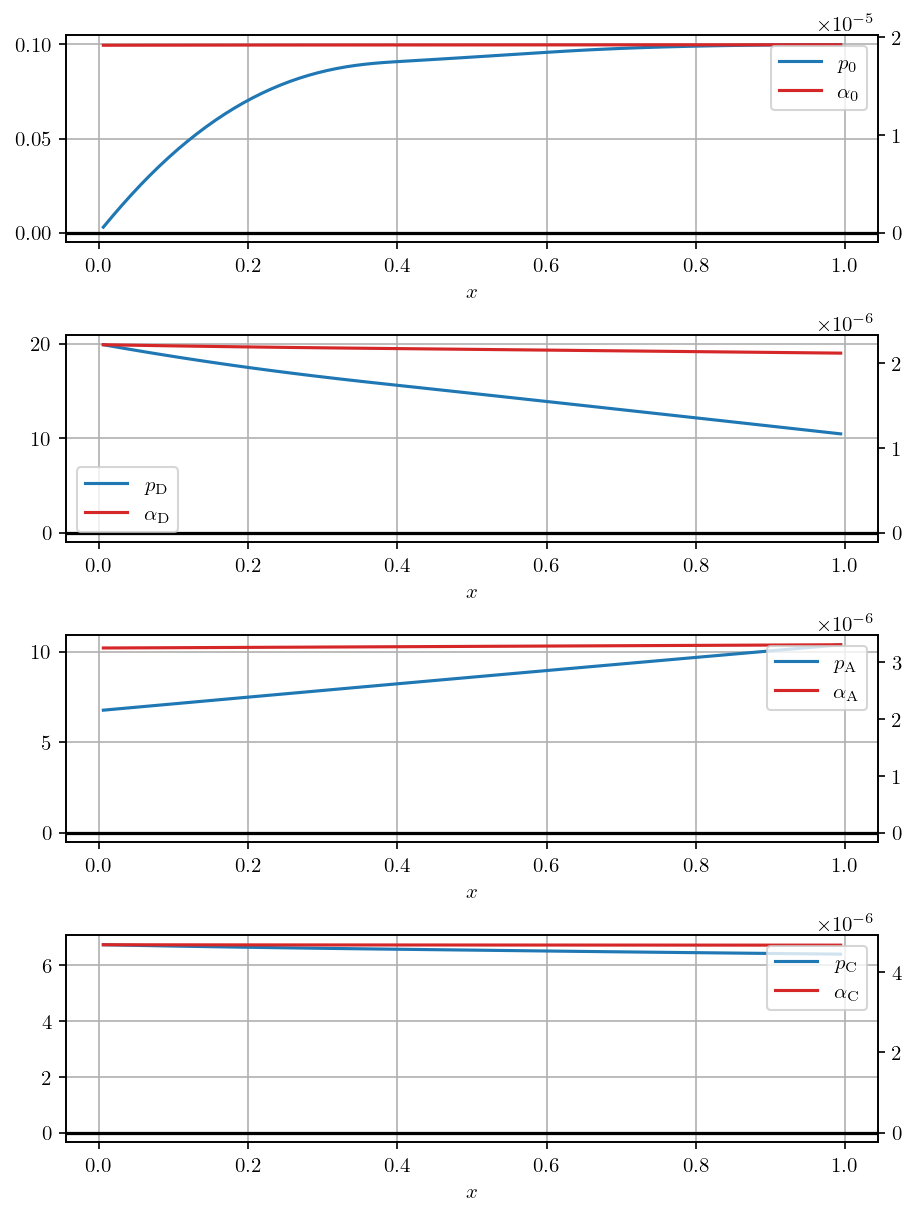

In [247]:
compartments = ['0','\mathrm{D}','\mathrm{A}','\mathrm{C}']
medulla = np.linspace(dx/2,1-dx/2,N)
fig, ax1 = plt.subplots(4,constrained_layout=True,figsize=(6,8))
plt.rcParams['text.usetex'] = True
for k in range(4):
    ax1[k].grid(True, which='both')
    ax1[k].axhline(y=0, color='k')
    plot1 = ax1[k].plot(medulla,y_p[-1,k,:]*pressure,label=r'$p_{}$'.format(compartments[k]))
    ax2 = ax1[k].twinx()
    ax2.axhline(y=0, color='k')
    plot2 = ax2.plot(medulla,y_alpha[-1,k,:]*area_tot,label=r'$\alpha_{}$'.format(compartments[k]),color='tab:red')
    # ax1[k].legend()
    # ax2.legend()
    plot = plot1+plot2
    labels = [l.get_label() for l in plot]
    # ax1[k].legend(plot, labels)
    ax2.legend(plot, labels)

plt.setp(ax1[:], xlabel=r"$x$")
# plt.setp(ax[:], ylabel=r"$$")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

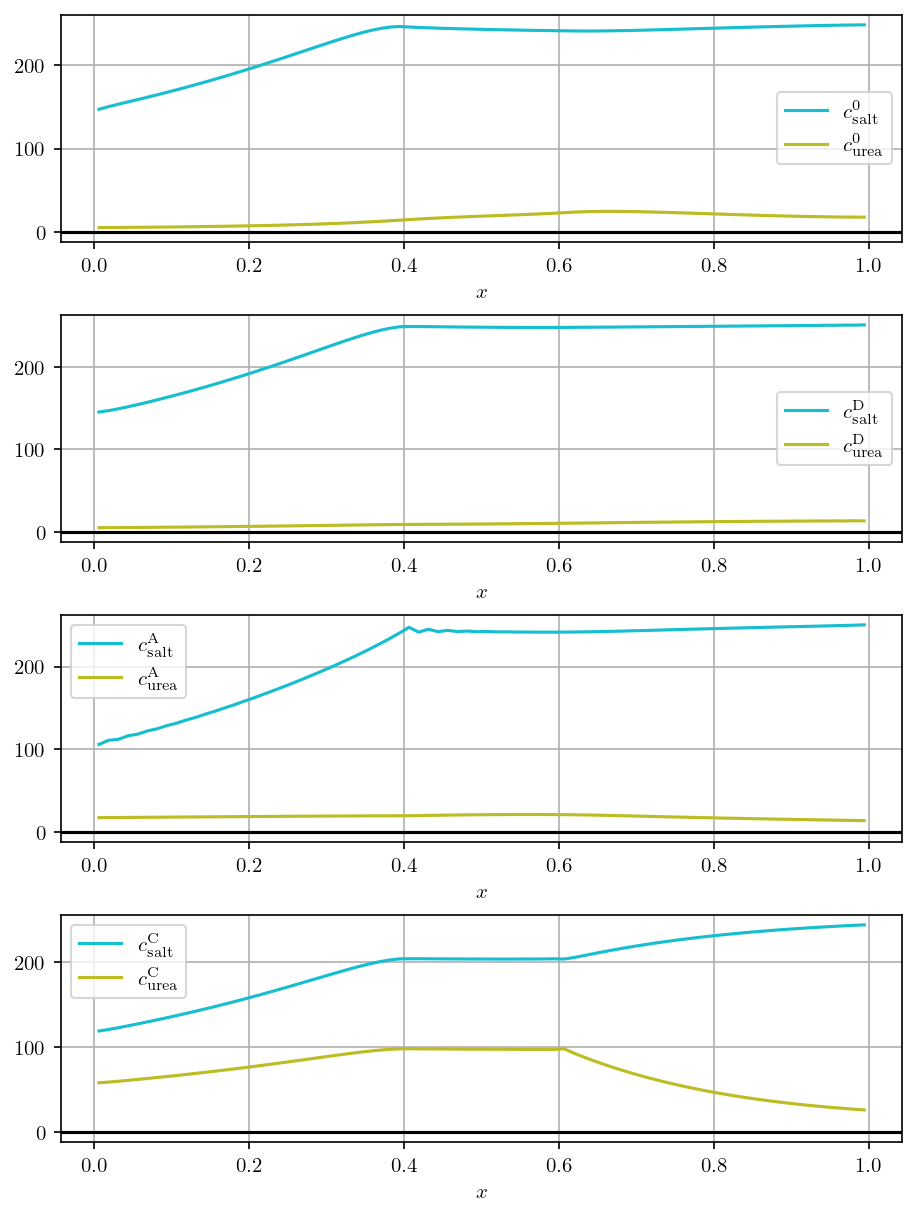

In [257]:
solutes = ['\mathrm{salt}','\mathrm{urea}']
fig, ax1 = plt.subplots(4,constrained_layout=True,figsize=(6,8))
plt.rcParams['text.usetex'] = True
for k in range(4):
    ax1[k].grid(True, which='both')
    ax1[k].axhline(y=0, color='k')
    ax1[k].plot(medulla,y_c[-1,0,k,:],label=r'$c_{}^{}$'.format(solutes[0],compartments[k]),color='tab:cyan')
    ax1[k].plot(medulla,y_c[-1,1,k,:],label=r'$c_{}^{}$'.format(solutes[1],compartments[k]),color='tab:olive')
    ax1[k].legend()

plt.setp(ax1[:], xlabel=r"$x$")
# plt.setp(ax[:], ylabel=r"$$")
plt.show

In [251]:
# save the progress

np.save('../results/6-6-2023/y',y)
np.save('../results/6-6-2023/y_alpha',y_alpha)
np.save('../results/6-6-2023/y_c',y_c)
np.save('../results/6-6-2023/y_p',y_p)

<function matplotlib.pyplot.show(close=None, block=None)>

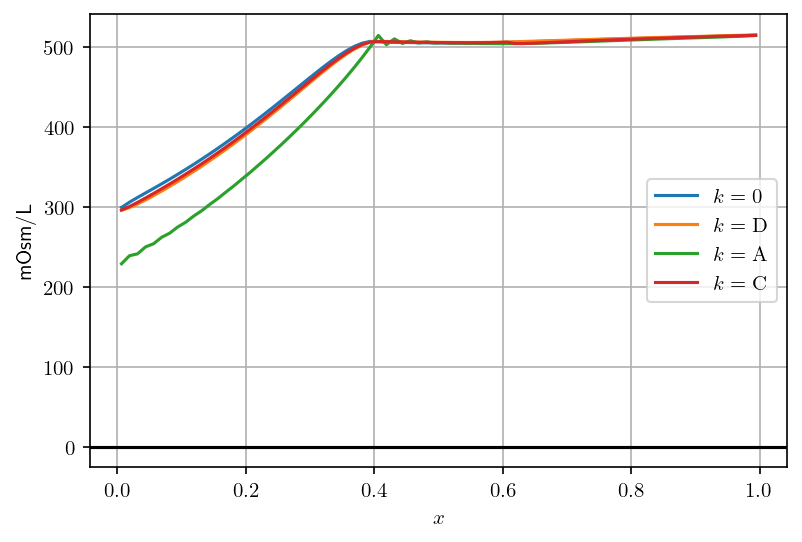

In [264]:
# Plotting osmolarity

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    ax.plot(medulla,2*y_c[-1,0,k,:]+y_c[-1,1,k,:],label=r'$k={}$'.format(compartments[k]))
ax.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"mOsm/L")
plt.show

In [159]:
# y_wflow = np.zeros((4,N+1))
# for k in range(4):
#     y_wflow[k,:] = np.abs(water_flow(k,y_alpha[-1],y_c[-1],y_p[-1],DCT_junc,F_PCT,P_v,P_p))

# fig, ax = plt.subplots()
# ax.grid(True, which='both')
# ax.axhline(y=0, color='k')
# plt.rcParams['text.usetex'] = True
# m_grid = np.linspace(0,1,N+1)
# for k in range(4):
#     ax.plot(m_grid,y_wflow[k,:],label=r'$|\alpha_{}u_{}|$'.format(compartments[k],compartments[k]))
# ax.legend()
# plt.xlabel(r"$x$")
# # plt.ylabel(r"$g(s)$")
# plt.show

NameError: name 'GFR' is not defined

In [ ]:
# y_wtrans = np.zeros((4,N))
# for k in range(4):
#     y_wtrans[k,:] = np.abs(water_trans(k,y_c[-1],y_p[-1]))

# fig, ax = plt.subplots()
# ax.grid(True, which='both')
# ax.axhline(y=0, color='k')
# plt.rcParams['text.usetex'] = True
# for k in range(4):
#     ax.plot(medulla,y_wtrans[k,:],label=r'$w_{}$'.format(compartments[k]))
# ax.legend()
# plt.xlabel(r"$x$")
# # plt.ylabel(r"$g(s)$")
# plt.show

Now, let's look at oscillation at the papillary end

In [235]:
Y = y[-1,:].copy()
m=1
# m = m+1

steps = 500
dt = 0.2

for n in range(steps):
    # PCT_flow = .5*np.tanh(n*dt/10)
    # PCT_flow = 5*np.tanh(n*dt/10)
    PCT_flow = F_PCT
    # PCT_flow = np.tanh(n/10)*(np.sin(n*np.pi/20))/4
    P_pap = P_p*(1-0.5*np.sin(4*n*dt*np.pi))
    Y = np.vstack((Y,np.zeros(16*N)))
    Y_0 = Y[-2,:]
    Y_1 = Y[-1,:]
    Y_1[:] = Y_0[:].copy()
    Y_1[:] = fsolve(implicit_func_res,Y_1,args=(Y_0,PCT_flow,P_v,P_pap))

from winsound import Beep
Beep(300, 200)
Beep(300, 200)
Beep(300, 200)

Y_alpha = Y[:,:4*N].reshape([m*steps+1,4,N])
Y_c = Y[:,4*N:(4+(2*4))*N].reshape([m*steps+1,2,4,N])
Y_p = Y[:,12*N:(12+4)*N].reshape([m*steps+1,4,N])